<a href="https://colab.research.google.com/github/huy-nguyen-fpt/btc-price-predict-xgboost/blob/main/AIL303m___AI1901__Nguyen_Quoc_Huy__Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Create data

## Fetch Fear & Greed Index Data (2018 - Now)

In [3]:
import requests
import pandas as pd

def get_fear_greed_index():
    url = "https://api.alternative.me/fng/?limit=50000"  # Lấy dữ liệu lịch sử tối đa
    response = requests.get(url)
    data = response.json()['data']

    df = pd.DataFrame(data)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')  # Chuyển timestamp thành datetime
    df = df[df['timestamp'] >= '2018-02-01']  # Lọc dữ liệu từ 2018 trở đi
    df = df[['timestamp', 'value', 'value_classification']]
    df.rename(columns={'value': 'fear_greed_index'}, inplace=True)
    df = df.sort_values(by='timestamp', ascending=True)  # Sắp xếp từ quá khứ đến hiện tại

    return df

df_fear_greed = get_fear_greed_index()
print(df_fear_greed.shape)
print(df_fear_greed.head())

(2723, 3)
      timestamp fear_greed_index value_classification
2722 2018-02-01               30                 Fear
2721 2018-02-02               15         Extreme Fear
2720 2018-02-03               40                 Fear
2719 2018-02-04               24         Extreme Fear
2718 2018-02-05               11         Extreme Fear


/tmp/ipython-input-3-3259162923.py:10: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')  # Chuyển timestamp thành datetime


## Data bitcoin from binance

In [2]:
from binance.client import Client
import pandas as pd

api_key = "YOUR_BINANCE_API_KEY"
api_secret = "YOUR_BINANCE_API_SECRET"

client = Client(api_key, api_secret)

def get_binance_data(symbol="BTCUSDT", interval=Client.KLINE_INTERVAL_1HOUR, start_date="1 Feb, 2018"):
    klines = client.get_historical_klines(symbol, interval, start_date)

    df = pd.DataFrame(klines, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_asset_volume', 'num_trades',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
    ])

    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')  # Chuyển timestamp thành datetime
    df[['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'num_trades']] = df[
        ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume',
         'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'num_trades']
    ].astype(float)

    return df

df_binance = get_binance_data()
print(df_binance.head())

ModuleNotFoundError: No module named 'binance'

# Feature engineering

In [ ]:
import numpy as np

# Tạo biến log của volume
df_binance['log_volume'] = np.log1p(df_binance['volume'])

# Tạo SMA (Simple Moving Average)
df_binance['sma_10'] = df_binance['close'].rolling(window=10).mean()

# Tạo EMA (Exponential Moving Average)
df_binance['ema_20'] = df_binance['close'].ewm(span=20, adjust=False).mean()

# Tạo RSI (Relative Strength Index)
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))
#RSI = chỉ báo đo sức mạnh và động lượng giá
# Dựa vào tỷ lệ giữa tăng và giảm trung bình trong 14 phiên

df_binance['rsi_14'] = compute_rsi(df_binance['close'])

# Chuyển Fear & Greed Index thành số học (0-100)
fear_greed_mapping = {"Extreme Fear": 10, "Fear": 30, "Neutral": 50, "Greed": 70, "Extreme Greed": 90}
df_fear_greed['fear_greed_score'] = df_fear_greed['value_classification'].map(fear_greed_mapping)

# Làm tròn timestamp của Fear & Greed Index về đúng ngày
df_fear_greed['timestamp'] = df_fear_greed['timestamp'].dt.floor('D')

# Merge dữ liệu Binance (1h) với Fear & Greed Index (theo ngày gần nhất)
df_merged = pd.merge_asof(df_binance.sort_values("timestamp"),
                          df_fear_greed.sort_values("timestamp"),
                          on="timestamp", direction="backward")

# Giữ lại dữ liệu từ 2018-05-01
df_merged = df_merged[df_merged['timestamp'] >= '2018-05-01']

# Xóa cột ignore vì không có ý nghĩa
df_merged.drop(columns=['ignore'], inplace=True, errors='ignore')


#  Tạo trung bình động 7 ngày cho Fear & Greed Index
df_merged['fear_greed_sma_7'] = df_merged['fear_greed_index'].rolling(window=7).mean()

#  Dùng log transformation cho Volume
df_merged['log_volume'] = np.log1p(df_merged['volume'])

#  Xem lại dữ liệu trước và sau khi xử lý
df_compare = df_merged[['timestamp', 'fear_greed_index', 'fear_greed_sma_7', 'volume', 'log_volume']].copy()

# df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'])  # Đảm bảo cột timestamp là datetime
# df_merged= df_merged.set_index('timestamp', inplace=False)  # Đặt timestamp làm index

df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'])


#  Thêm các biến seasonality
df_merged['day_of_week'] = df_merged['timestamp'].dt.dayofweek
df_merged['day_of_month'] = df_merged['timestamp'].dt.day
df_merged['month'] = df_merged['timestamp'].dt.month
df_merged['hour'] = df_merged['timestamp'].dt.hour
df_merged['quarter'] = df_merged['timestamp'].dt.quarter

#  Thêm Lag Features - Cho mô hình thấy giá trị trước đó để học xu hướng
df_merged['lag_1'] = df_merged['close'].shift(1)
df_merged['lag_6'] = df_merged['close'].shift(6)
df_merged['lag_24'] = df_merged['close'].shift(24)

#  Loại bỏ NaN
df_merged.dropna(inplace=True)

# Lưu dữ liệu sau khi xử lý vào file CSV
df_merged.to_csv("binance_fear_greed_xgboost_data.csv", index=False)

print(df_merged.dtypes)



               timestamp     open     high      low    close       volume  \
2103 2018-05-01 00:00:00  9246.01  9248.99  8934.44  8955.01  5263.799551   
2104 2018-05-01 01:00:00  8955.13  9020.99  8870.00  8994.99  4347.876744   
2105 2018-05-01 02:00:00  8994.98  9046.00  8921.89  9009.11  2314.013846   
2106 2018-05-01 03:00:00  9009.11  9019.71  8904.99  8938.01  1707.447469   
2107 2018-05-01 04:00:00  8938.50  9014.99  8938.01  8975.02  1265.039689   

         close_time  quote_asset_volume  num_trades  \
2103  1525136399999        4.765986e+07     35801.0   
2104  1525139999999        3.891312e+07     25537.0   
2105  1525143599999        2.080822e+07     14129.0   
2106  1525147199999        1.530629e+07     11907.0   
2107  1525150799999        1.136527e+07      8188.0   

      taker_buy_base_asset_volume  taker_buy_quote_asset_volume ignore  \
2103                  2117.178691                  1.916536e+07      0   
2104                  2210.320034                  1.97937

<ipython-input-6-bc4cd077800e>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged.drop(columns=['ignore'], inplace=True, errors='ignore')


 Dữ liệu đã được cập nhật và lưu vào binance_fear_greed_xgboost_data.csv!


In [4]:
df_merged = pd.read_csv("/content/binance_fear_greed_xgboost_data.csv")

# Bitcoin price trend chart over time

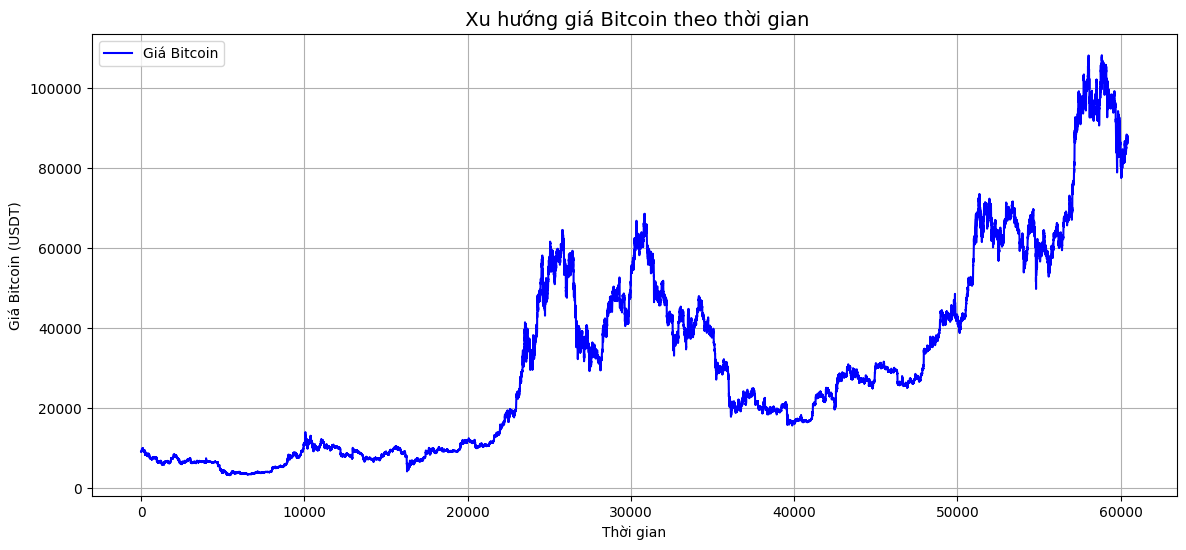

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df_merged.index, df_merged['close'], label="Giá Bitcoin", color='blue')

plt.title(" Xu hướng giá Bitcoin theo thời gian", fontsize=14)
plt.xlabel("Thời gian")
plt.ylabel("Giá Bitcoin (USDT)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.2 MB/s eta 0:00:00


In [ ]:
# 🔹 Import thư viện
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from skopt import BayesSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


# 🔹 Load dữ liệu
file_path = "drive/MyDrive/binance_fear_greed_xgboost_data.csv"
df = pd.read_csv(file_path, parse_dates=['timestamp'])
df.set_index('timestamp', inplace=True)

Mounted at /content/drive


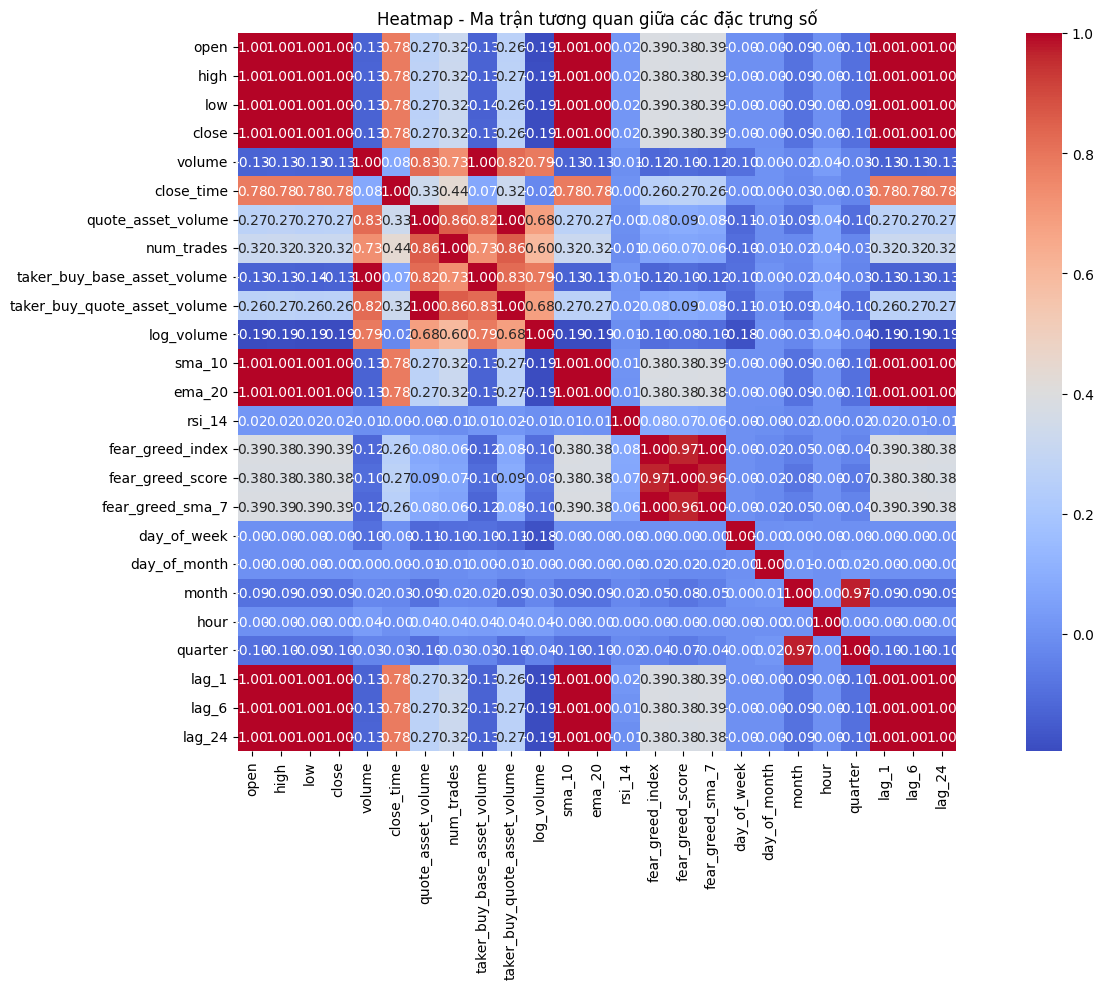

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lọc các cột số (int, float)
df_numeric = df.select_dtypes(include=['number'])

# Tính ma trận tương quan
corr_matrix = df_numeric.corr()

# Vẽ heatmap
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Heatmap - Ma trận tương quan giữa các đặc trưng số")
plt.tight_layout()
plt.show()


In [ ]:
# 🔹 Chọn features và target
X = df.drop(columns=['close','value_classification'])
y = df['close']


MinMaxScaler → RMSE: 0.153450, R2: 0.285680
StandardScaler → RMSE: 0.648314, R2: 0.285997


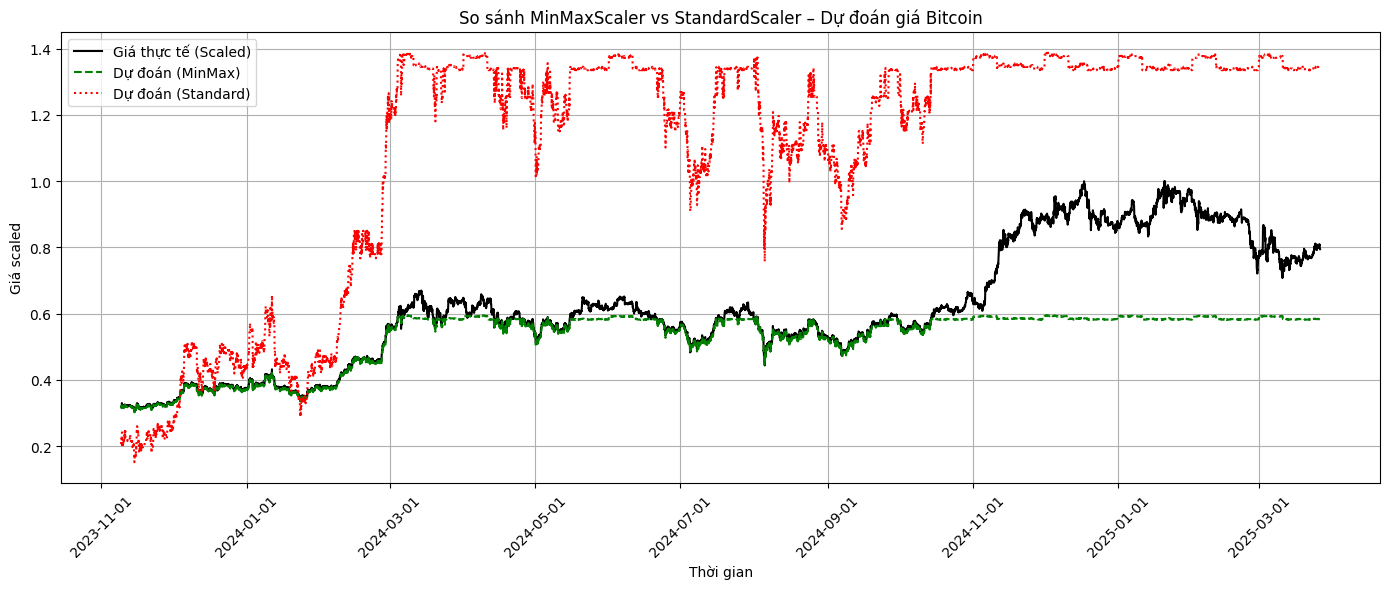

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

#  MinMax Scaler
mm_X = MinMaxScaler()
mm_y = MinMaxScaler()

X_mm_scaled = mm_X.fit_transform(X)
y_mm_scaled = mm_y.fit_transform(y.values.reshape(-1, 1)).ravel()

X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(
    X_mm_scaled, y_mm_scaled, test_size=0.2, shuffle=False
)

#  Standard Scaler
std_X = StandardScaler()
std_y = StandardScaler()

X_std_scaled = std_X.fit_transform(X)
y_std_scaled = std_y.fit_transform(y.values.reshape(-1, 1)).ravel()

X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(
    X_std_scaled, y_std_scaled, test_size=0.2, shuffle=False
)

#  Mô hình XGBoost dùng chung cho cả hai
model_minmax = XGBRegressor(n_estimators=400, max_depth=5, learning_rate=0.01, objective='reg:squarederror')
model_standard = XGBRegressor(n_estimators=400, max_depth=5, learning_rate=0.01, objective='reg:squarederror')

model_minmax.fit(X_train_mm, y_train_mm)
model_standard.fit(X_train_std, y_train_std)

#  Dự đoán
y_pred_mm = model_minmax.predict(X_test_mm)
y_pred_std = model_standard.predict(X_test_std)

#  Đánh giá
rmse_mm = np.sqrt(mean_squared_error(y_test_mm, y_pred_mm))
r2_mm = r2_score(y_test_mm, y_pred_mm)

rmse_std = np.sqrt(mean_squared_error(y_test_std, y_pred_std))
r2_std = r2_score(y_test_std, y_pred_std)

print(f"MinMaxScaler → RMSE: {rmse_mm:.6f}, R2: {r2_mm:.6f}")
print(f"StandardScaler → RMSE: {rmse_std:.6f}, R2: {r2_std:.6f}")

#  Tạo mốc thời gian cho biểu đồ
split_point = int(len(X) * 0.8)
index_test = X.index[split_point:]

#  Biểu đồ so sánh
plt.figure(figsize=(14, 6))
plt.plot(index_test, y_test_mm, label="Giá thực tế (Scaled)", color="black")
plt.plot(index_test, y_pred_mm, label="Dự đoán (MinMax)", linestyle="--", color="green")
plt.plot(index_test, y_pred_std, label="Dự đoán (Standard)", linestyle=":", color="red")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.title("So sánh MinMaxScaler vs StandardScaler – Dự đoán giá Bitcoin")
plt.xlabel("Thời gian")
plt.ylabel("Giá scaled")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# split data thứ 1 và chuẩn hóa

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler

#  Bước 1: Chuẩn hóa toàn bộ dữ liệu
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

#  Bước 2: Chia theo tỷ lệ 80% Train - 20% Test, giữ nguyên thứ tự thời gian
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_scaled,
    test_size=0.2,
    shuffle=False  #  Không xáo trộn dữ liệu để giữ tính chuỗi thời gian
)


# mô hình 1

 RMSE - Mô hình 1 (No Regu, No Hyper): 0.15344968
 R2 Score - Mô hình 1 (No Regu, No Hyper): 0.28567991


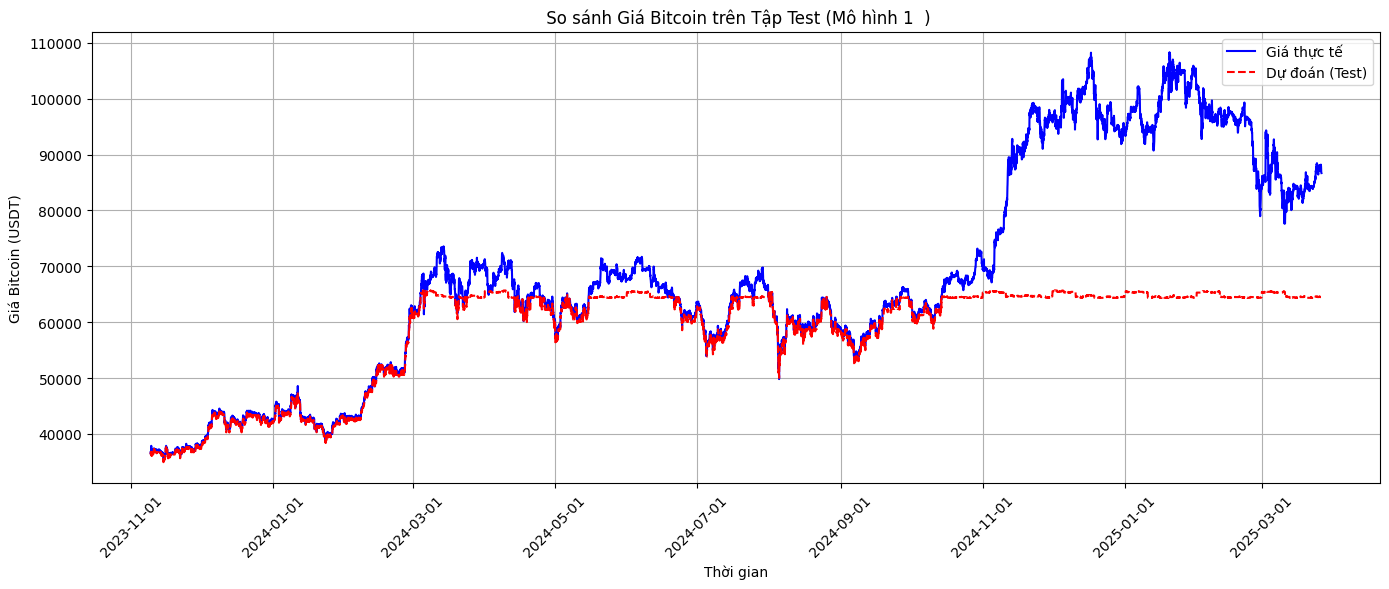

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np


#  Huấn luyện mô hình XGBoost đơn giản (không tuning, không regularization)
model_1 = XGBRegressor(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.01,
    objective='reg:squarederror'
)

#  Fit trên tập train
model_1.fit(X_train_scaled, y_train_scaled)

#  Dự đoán trên tập test
y_pred_1_scaled = model_1.predict(X_test_scaled)


#  Tính RMSE
rmse_1 = np.sqrt(mean_squared_error(y_test_scaled, y_pred_1_scaled))
print(f" RMSE - Mô hình 1 (No Regu, No Hyper): {rmse_1:.8f}")
r2 = r2_score(y_test_scaled, y_pred_1_scaled)
print(f" R2 Score - Mô hình 1 (No Regu, No Hyper): {r2:.8f}")

split_point = int(len(X) * 0.8)
index_test = X.index[split_point:]

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
y_test = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()
y_pred = scaler_y.inverse_transform(y_pred_1_scaled.reshape(-1, 1)).ravel()

plt.figure(figsize=(14, 6))
plt.plot(index_test, y_test, label="Giá thực tế", color='blue')
plt.plot(index_test, y_pred, label="Dự đoán (Test)", color='red', linestyle="dashed")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.title(" So sánh Giá Bitcoin trên Tập Test (Mô hình 1  )")
plt.xlabel("Thời gian")
plt.ylabel("Giá Bitcoin (USDT)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()





# mô hình 2 có regularization

 RMSE - Mô hình 2 (Regu, No Hyper): 0.15336035
 R2 Score - Mô hình 2 (Regu, No Hyper): 0.28651133


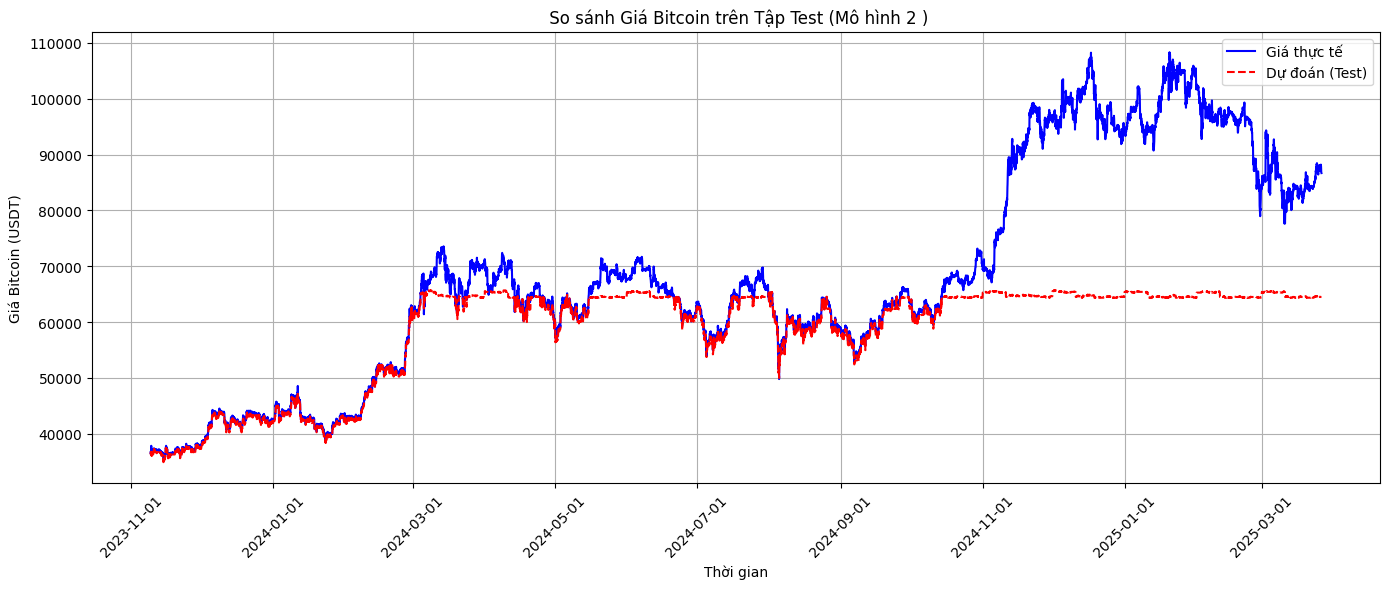

In [ ]:
#  Khởi tạo mô hình với regularization (alpha, lambda)  sử dụng Regularization để giảm overfiting
model_2 = XGBRegressor(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.01,
    reg_alpha=0.01,
    reg_lambda=0.05,
    objective='reg:squarederror'
    , tree_method='hist'
)

#  Huấn luyện trên tập train
model_2.fit(X_train_scaled, y_train_scaled)

#  Dự đoán trên tập test
y_pred_2_scaled = model_2.predict(X_test_scaled)
# y_pred_2 = scaler_y.inverse_transform(y_pred_2_scaled.reshape(-1, 1)).ravel()

#  Tính RMSE
rmse_2 = np.sqrt(mean_squared_error(y_test_scaled, y_pred_2_scaled))
print(f" RMSE - Mô hình 2 (Regu, No Hyper): {rmse_2:.8f}")
r2 = r2_score(y_test_scaled, y_pred_2_scaled)
print(f" R2 Score - Mô hình 2 (Regu, No Hyper): {r2:.8f}")

split_point = int(len(X) * 0.8)
index_test = X.index[split_point:]

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

y_test = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()
y_pred = scaler_y.inverse_transform(y_pred_2_scaled.reshape(-1, 1)).ravel()

plt.figure(figsize=(14, 6))
plt.plot(index_test, y_test, label="Giá thực tế", color='blue')
plt.plot(index_test, y_pred, label="Dự đoán (Test)", color='red', linestyle="dashed")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.title(" So sánh Giá Bitcoin trên Tập Test (Mô hình 2 )")
plt.xlabel("Thời gian")
plt.ylabel("Giá Bitcoin (USDT)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# mô hình 3  có regularization , có hyperturning

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

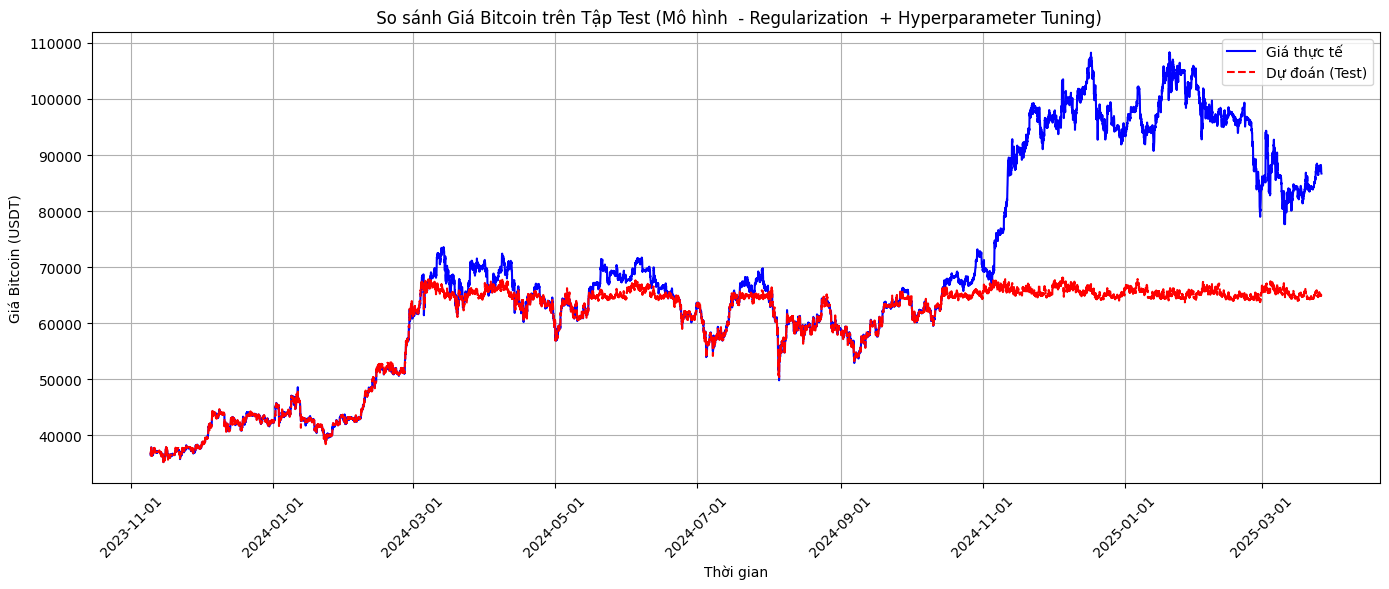

In [ ]:
from skopt.callbacks import DeltaYStopper
from skopt import BayesSearchCV
from xgboost import XGBRegressor

# #  Không gian tìm kiếm với Regularization

 # BAYES SEARCH CV

param_space = {
    'n_estimators': (200, 1000),
    'learning_rate': (0.05, 0.3, 'log-uniform'),
    'max_depth': (4, 20),
    'subsample': (0.7, 1.0),
    'colsample_bytree': (0.7, 1.0),
    'reg_alpha': (0.001, 10.0, 'log-uniform'), # sử dụng Hyperparameter Tuning để tìm siêu tham số (có cả Regularization )
    'reg_lambda': (0.1, 10.0, 'log-uniform'),
    'min_child_weight': (1, 10),
    'gamma': (0, 2.0),
    'max_leaves': (10, 100),
    'grow_policy': ['depthwise'],
    'max_bin': (64, 256)
}

#  Tuning với BayesSearchCV (trên tập train 80%)
bayes_search = BayesSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror'),
    search_spaces=param_space,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_iter=100,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

early_stopper = DeltaYStopper(0.01)

bayes_search.fit(X_train_scaled, y_train_scaled)

#  In ra tham số tốt nhất
best_params = bayes_search.best_params_
print(" Best Parameters (Mô hình 3):", best_params)

#  Mô hình 3: Có Regularization + Tuning
model_3 = XGBRegressor(objective='reg:squarederror', tree_method='hist',**best_params)
model_3.fit(X_train_scaled, y_train_scaled)

#  Dự đoán trên tập test
y_pred_3_scaled = model_3.predict(X_test_scaled)
#y_pred_3 = scaler_y.inverse_transform(y_pred_3_scaled.reshape(-1, 1)).ravel()

#  Tính RMSE
rmse_3 = np.sqrt(mean_squared_error(y_test_scaled, y_pred_3_scaled))
print(f" RMSE - Mô hình 3 (Regu + Hyper): {rmse_3:.8f}")

split_point = int(len(X) * 0.8)
index_test = X.index[split_point:]

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

y_test = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()
y_pred = scaler_y.inverse_transform(y_pred_3_scaled.reshape(-1, 1)).ravel()

plt.figure(figsize=(14, 6))
plt.plot(index_test, y_test, label="Giá thực tế", color='blue')
plt.plot(index_test, y_pred, label="Dự đoán (Test)", color='red', linestyle="dashed")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.title(" So sánh Giá Bitcoin trên Tập Test (Mô hình  - Regularization  + Hyperparameter Tuning)")
plt.xlabel("Thời gian")
plt.ylabel("Giá Bitcoin (USDT)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


,Mô hình,RMSE
0,"No Regu, No Hyper",0.153450
1,"Regu, No Hyper",0.153360
2,"Regu, Hyper",0.149969


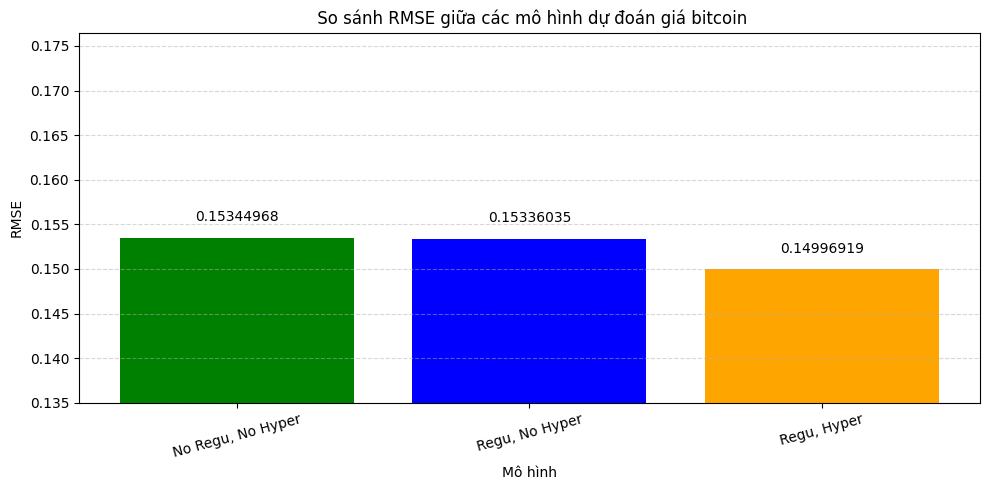

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# 🔹 Lưu kết quả vào DataFrame
results = pd.DataFrame({
    "Mô hình": ["No Regu, No Hyper", "Regu, No Hyper",  "Regu, Hyper"],
    "RMSE": [rmse_1, rmse_2, rmse_3]
})

# 🔹 Hiển thị bảng
display(results)

# 🔹 Vẽ biểu đồ cột so sánh RMSE
plt.figure(figsize=(10, 5))
bars = plt.bar(results["Mô hình"], results["RMSE"], color=["green", "blue", "orange"])

# Thêm nhãn giá trị RMSE trên mỗi cột
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01 * max(results["RMSE"]),
             f"{height:.8f}", ha='center', va='bottom', fontsize=10)

plt.title(" So sánh RMSE giữa các mô hình dự đoán giá bitcoin")
plt.xlabel("Mô hình")
plt.ylabel("RMSE")
plt.ylim(min(results["RMSE"]) * 0.9, max(results["RMSE"]) * 1.15)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np


# Convert ngược lại X_train_scaled và X_test_scaled
X_train = scaler_X.inverse_transform(X_train_scaled)
X_test = scaler_X.inverse_transform(X_test_scaled)

# Convert ngược lại y_train_scaled và y_test_scaled (nếu cần)
y_train = scaler_y.inverse_transform(y_train_scaled.reshape(-1, 1))
y_test = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))


mean_train = np.mean(y_train, axis=0)
mean_test = np.mean(y_test, axis=0)
cov_train = np.cov(X_train, rowvar=False)
cov_test = np.cov(X_test, rowvar=False)

print('mean of close price in train set',mean_train)
print('mean of close price in test set ',mean_test)


mean of close price in train set [21964.83568854]
mean of close price in test set  [67942.66284638]


# split data lần 2

In [ ]:
# 🔹 Chọn features và target
features = ['log_volume', 'num_trades', 'fear_greed_sma_7', 'sma_10', 'ema_20',
            'day_of_week', 'day_of_month', 'month', 'hour', 'quarter',
            'lag_1', 'lag_6', 'lag_24']
target = 'close'

X = df[features]
y = df[target]

# 🔹 Sử dụng MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# 🔹 Chia dữ liệu theo mốc thời gian
train_end = "2023-12-31"
val_start = "2024-01-01"
val_end = "2024-11-30"
test_start = "2024-12-01"
test_end = "2025-03-14"

X_train = df.loc[:train_end][features]
X_validation = df.loc[val_start:val_end][features]
X_test = df.loc[test_start:test_end][features]

y_train = df.loc[:train_end][target]
y_validation = df.loc[val_start:val_end][target]
y_test = df.loc[test_start:test_end][target]

# 🔹 Scale dữ liệu
X_train_scaled = scaler_X.transform(X_train)
X_validation_scaled = scaler_X.transform(X_validation)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1)).ravel()
y_validation_scaled = scaler_y.transform(y_validation.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# tìm siêu tham số (cả Regularization )

In [ ]:

# 🔹 Tạo không gian tìm kiếm siêu tham số
param_space = {
    'n_estimators': (100, 2000),
    'learning_rate': (0.01, 1, 'log-uniform'),
    'max_depth': (3, 15),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'reg_alpha': (1e-3, 10.0, 'log-uniform'),
    'reg_lambda': (1e-3, 20.0, 'log-uniform'),
    'min_child_weight': (1, 20),
    'gamma': (0.1, 10.0),
    'max_leaves': (0, 100),
    'grow_policy': ['depthwise', 'lossguide'],
    'max_bin': (32, 512),
}

bayes_search = BayesSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror'),
    search_spaces=param_space,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_iter=50,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

bayes_search.fit(X_train_scaled, y_train_scaled)

# 🔹 In ra kết quả tốt nhất
best_params_2 = bayes_search.best_params_
print(" Best Parameters:", best_params_2)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

# sử dụng xgboost bằng kĩ thuật rolling window

In [ ]:
import xgboost as xgb

#  Kết hợp tập Validation và Test
X_combined = pd.concat([X_validation, X_test])
y_combined = pd.concat([y_validation, y_test])

#  Scale lại dữ liệu kết hợp
X_combined_scaled = scaler_X.transform(X_combined)
y_combined_scaled = scaler_y.transform(y_combined.values.reshape(-1, 1)).ravel()

#  Cấu hình Rolling Window Expanding
test_window_size = 12  # Số bước dự đoán mỗi lần

rmse_scores = []
combined_predictions = []
combined_actuals = []
combined_dates = []

# Khởi tạo tập train mở rộng ban đầu
X_train_expanded = X_train_scaled.copy()
y_train_expanded = y_train_scaled.copy()

# Chuyển sang DMatrix
feature_names = X_train.columns.tolist()
dtrain = xgb.DMatrix(X_train_expanded, label=y_train_expanded, feature_names=feature_names)


# Khởi tạo tham số mô hình (dựa trên best_params_2)
xgb_params = {
    'objective': 'reg:squarederror',
    'learning_rate': best_params_2['learning_rate'],
    'max_depth': best_params_2['max_depth'],
    'subsample': best_params_2['subsample'],
    'colsample_bytree': best_params_2['colsample_bytree'],
    'reg_alpha': best_params_2['reg_alpha'],
    'reg_lambda': best_params_2['reg_lambda'],
    'min_child_weight': best_params_2['min_child_weight'],
    'gamma': best_params_2['gamma'],
    'max_leaves': best_params_2['max_leaves'],
    'grow_policy': best_params_2['grow_policy'],
    'max_bin': best_params_2['max_bin'],
    'tree_method': 'hist',
}

# Huấn luyện lần đầu
model = xgb.train(xgb_params, dtrain, num_boost_round=100)

#  Bắt đầu Rolling Window Expanding
while len(X_combined) > test_window_size:
    # Lấy cửa sổ test
    X_val_test, X_combined = X_combined[:test_window_size], X_combined[test_window_size:]
    y_val_test, y_combined = y_combined[:test_window_size], y_combined[test_window_size:]

    X_val_test_scaled = scaler_X.transform(X_val_test)
    y_val_test_scaled = scaler_y.transform(y_val_test.values.reshape(-1, 1)).ravel()

    dtest = xgb.DMatrix(X_val_test_scaled, feature_names=feature_names)

    #  Dự đoán giá trị
    y_pred_scaled = model.predict(dtest)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    y_actual = scaler_y.inverse_transform(y_val_test_scaled.reshape(-1, 1)).ravel()

    combined_predictions.extend(y_pred)
    combined_actuals.extend(y_actual)
    combined_dates.extend(X_val_test.index)

    rmse = np.sqrt(mean_squared_error(y_val_test_scaled, y_pred_scaled))
    rmse_scores.append(rmse)
    print(f" Rolling Expanding RMSE (1 khối 12 giờ): {rmse:.4f}")

    #  Cập nhật mô hình với dữ liệu mới (train tiếp)
    X_train_expanded = np.vstack([X_train_expanded, X_val_test_scaled])
    y_train_expanded = np.hstack([y_train_expanded, y_val_test_scaled])

    dtrain_updated = xgb.DMatrix(X_train_expanded, label=y_train_expanded, feature_names=feature_names)

    model = xgb.train(xgb_params, dtrain_updated, num_boost_round=50, xgb_model=model)





 Rolling Expanding RMSE (1 khối 12 giờ): 0.0705
 Rolling Expanding RMSE (1 khối 12 giờ): 0.0452
 Rolling Expanding RMSE (1 khối 12 giờ): 0.0317
 Rolling Expanding RMSE (1 khối 12 giờ): 0.0166
 Rolling Expanding RMSE (1 khối 12 giờ): 0.0105
 Rolling Expanding RMSE (1 khối 12 giờ): 0.0057
 Rolling Expanding RMSE (1 khối 12 giờ): 0.0043
 Rolling Expanding RMSE (1 khối 12 giờ): 0.0043
 Rolling Expanding RMSE (1 khối 12 giờ): 0.0028
 Rolling Expanding RMSE (1 khối 12 giờ): 0.0029
 Rolling Expanding RMSE (1 khối 12 giờ): 0.0015
 Rolling Expanding RMSE (1 khối 12 giờ): 0.0021
 Rolling Expanding RMSE (1 khối 12 giờ): 0.0019
 Rolling Expanding RMSE (1 khối 12 giờ): 0.0022
 Rolling Expanding RMSE (1 khối 12 giờ): 0.0032
 Rolling Expanding RMSE (1 khối 12 giờ): 0.0069
 Rolling Expanding RMSE (1 khối 12 giờ): 0.0024
 Rolling Expanding RMSE (1 khối 12 giờ): 0.0047
 Rolling Expanding RMSE (1 khối 12 giờ): 0.0016
 Rolling Expanding RMSE (1 khối 12 giờ): 0.0055
 Rolling Expanding RMSE (1 khối 12 giờ):

In [ ]:
#  Tính RMSE tổng hợp
mean_rmse = np.mean(rmse_scores)
final_rmse = np.sqrt(mean_squared_error(
    scaler_y.transform(np.array(combined_actuals).reshape(-1, 1)),
    scaler_y.transform(np.array(combined_predictions).reshape(-1, 1))
))


# print(" Trung bình RMSE theo từng khối 12 giờ (mean RMSE): {:.4f}".format(mean_rmse))
print(" RMSE tổng thể sau khi rolling hoàn tất (final RMSE): {:.4f}".format(final_rmse))
#  Lưu mô hình sau khi hoàn tất training
model.save_model("xgboost_bitcoin.model")
print(" Mô hình đã được lưu thành công!")

 RMSE tổng thể sau khi rolling hoàn tất (final RMSE): 0.0198


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:48:09] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


 Mô hình đã được lưu thành công!


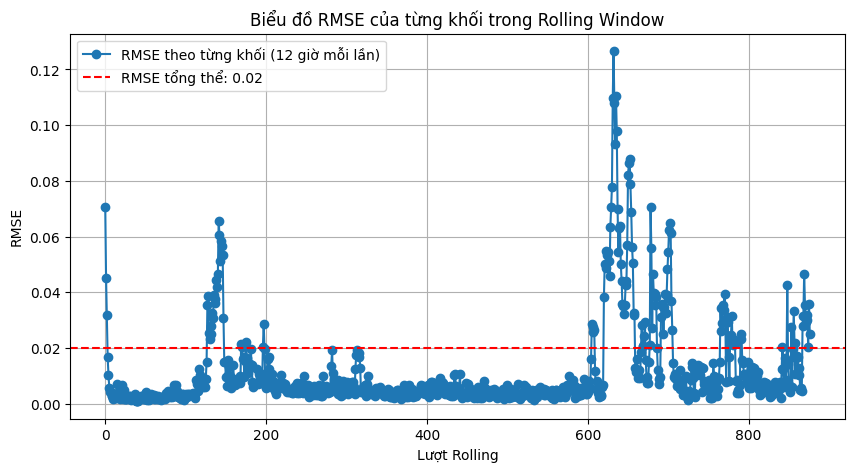

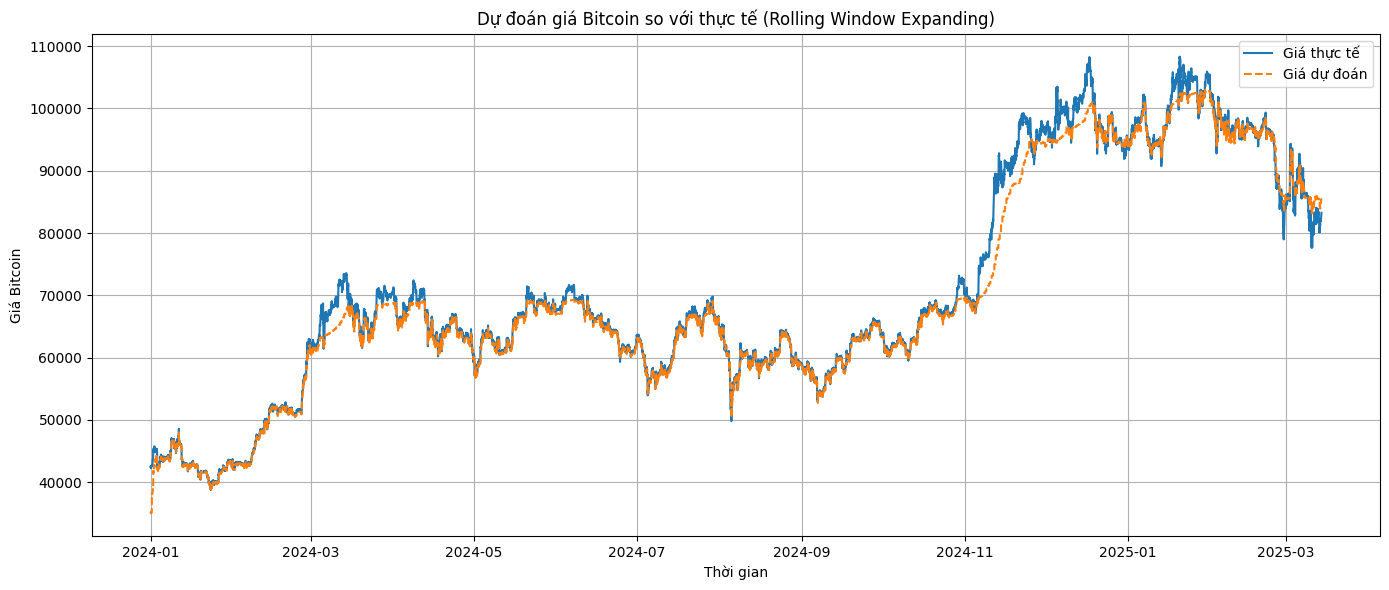

In [ ]:

# -----------------------------------------
#  1. Vẽ biểu đồ RMSE theo từng khối
# -----------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(len(rmse_scores)), rmse_scores, marker='o', label="RMSE theo từng khối (12 giờ mỗi lần)")
plt.axhline(final_rmse, color='red', linestyle='--', label=f'RMSE tổng thể: {final_rmse:.2f}')
plt.xlabel("Lượt Rolling")
plt.ylabel("RMSE")
plt.title("Biểu đồ RMSE của từng khối trong Rolling Window")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------------------
# 2. Vẽ biểu đồ dự đoán vs thực tế theo thời gian
# -----------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(combined_dates, combined_actuals, label='Giá thực tế',linestyle='-')
plt.plot(combined_dates, combined_predictions, label='Giá dự đoán', linestyle='--' )
plt.xlabel("Thời gian")
plt.ylabel("Giá Bitcoin")
plt.title("Dự đoán giá Bitcoin so với thực tế (Rolling Window Expanding)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()